# First Exploration and Tests

This Notebook is a part of the Thesis Project: Learning Multilingual Document Representations.

It serves the purpose of exploring samples of the relevant Datasets and testing some basic algorithms. 

So far it contains:

- Loading and Preprocessing Data of JRQ-Arquis (Sample, English-French)
- Traning some baseline document embeddings using gensim
- Implementing a basic Concept approximation function, which maps document representations from one language to another


##  1. Loading and preprocessing of the Dataset

Load file, transform the XML into a usable format in this context

In [1]:
from Utils import extract_docs_from_jrq_xml
import xml.etree.ElementTree as ET


# parse an xml file by name
tree = ET.parse('Data/sample_jrc-en-fr.xml')
documents = extract_docs_from_jrq_xml(tree, align="documents")


Since we want to train models and do some parameter selection later on, it makes sense to split the dataset into a training and test dataset. From now on, we will apply all methods only to the training dataset. Later on, we will use the test dataset to evaluate the performance of the learned functions. 

In [2]:
from sklearn.model_selection import train_test_split
documents, test_documents = train_test_split(documents, test_size=0.25, random_state=42)

Lets take a look: 

In [3]:
#show whats in there
print(documents[1].keys())
print(documents[1]["english"][:100])
print(documents[1]["french"][:100])

dict_keys(['english', 'french'])
EUROPEAN AGREEMENT ON THE EXCHANGE OF TISSUE-TYPING REAGENTSTHE MEMBER STATES OF THE COUNCIL OF EURO
LES ETATS SIGNATAIRES DU PRESENT ACCORD , MEMBRES DU CONSEIL DE L'EUROPE ,considérant que les réacti


-> Preprocessing: Tokenization, lemmatization

In [4]:
from Preprocessor import Preprocessor
#Recources needed, uncomment if needed/error   
#nltk.download('punkt')
#nltk.download('wordnet')

# Make sure no empty documents are passed, filter those
filtered_docs = []
for doc in documents:
    if len(doc["english"]) > 0 and len(doc["french"]) > 0:
        filtered_docs.append(doc)
        
#preprocessing, text -> tokenized and stemmed/lemmatized words       
preprocessor_english = Preprocessor(language="en")
preprocessor_french = Preprocessor(language="fr")

french_docs_preprocessed = [preprocessor_french.preprocess(doc["french"]) for doc in filtered_docs]
english_docs_preprocessed = [preprocessor_english.preprocess(doc["english"]) for doc in filtered_docs]


Take a look at a snippet of the preprocessed documents: 

In [5]:
print(french_docs_preprocessed[1][:10])
print(english_docs_preprocessed[1][:10])

['desir', 'de', 'facilit', 'le', 'transport', 'international', 'de', 'marchandis', 'par', 'v']
['custom', 'convention', 'on', 'the', 'international', 'transport', 'of', 'good', 'under', 'cover']


## 2.Training of the Monlingual Representations

The first step is to prepare the data: 

In [6]:
from Utils import create_corpus
     
french_dictionary, french_corpus = create_corpus(french_docs_preprocessed)
english_dictionary, english_corpus = create_corpus(english_docs_preprocessed)

In [7]:
print(french_dictionary)
print("Example BOW Representation:")
print(french_corpus[0][:10])
print("...")

Dictionary(1225 unique tokens: ['10', '101', '11', '111', '2']...)
Example BOW Representation:
[(0, 1), (1, 1), (2, 2), (3, 1), (4, 9), (5, 1), (6, 4), (7, 1), (8, 4), (9, 1)]
...


Now Prepare Monolingual Representations: 

In [8]:
from gensim import models

french_tfidf = models.TfidfModel(french_corpus)
french_corpus_tfidf = french_tfidf[french_corpus]

english_tfidf = models.TfidfModel(english_corpus)
english_corpus_tfidf = english_tfidf[english_corpus]


french_lsi_model = models.LsiModel(french_corpus_tfidf, 
                            id2word=french_dictionary, 
                            num_topics=12)  

english_lsi_model = models.LsiModel(english_corpus_tfidf, 
                            id2word=english_dictionary, 
                            num_topics=12) 

-> Example of Topic Representation

In [9]:
english_lsi_model[english_corpus_tfidf[2]]

[(0, -0.412284474690649),
 (1, -0.8934395936123091),
 (2, 0.002979588799599836),
 (3, 0.03563567422495872),
 (4, 0.06258526905485748),
 (5, 0.1136560857361848),
 (6, -0.016277102913936508),
 (7, 0.011661097382099623),
 (8, 0.011929362311448198),
 (9, 0.006625283858239668),
 (10, 0.007710962781016675),
 (11, 0.015893974577204012)]

# 3. Linear Concept Approximation
- The goal is to find a mapping $\phi : C_{X} \rightarrow{C_{Y}}$ 
- Therefore it is more convenient to have vector and matrix represenations using numpy

In [10]:
import numpy as np
#Convert the Tuple representations into Numpy vectors
english_lsi_vec = english_lsi_model[list(english_corpus_tfidf)]
english_lsi_vec = list(english_lsi_vec)
english_lsi_vecs = []
for tupel_list in english_lsi_vec:
    vec_rep = list(zip(*tupel_list))
    english_lsi_vecs.append(np.array(vec_rep[1]))

french_lsi_vec = french_lsi_model[list(french_corpus_tfidf)]
french_lsi_vec = list(french_lsi_vec)
french_lsi_vecs = []
for tupel_list in french_lsi_vec:
    vec_rep = list(zip(*tupel_list))
    french_lsi_vecs.append(np.array(vec_rep[1]))

In [11]:
print("Concept Vector of the first English document:")
print(str(english_lsi_vecs[0])+"\n")
print("Concept Vector of the first French document:")
print(french_lsi_vecs[0])

Concept Vector of the first English document:
[-0.39576543  0.09476488 -0.01398168 -0.07049837 -0.41842655  0.0268391
 -0.14419617  0.08294239  0.08113263  0.19187567 -0.07752568  0.49057364]

Concept Vector of the first French document:
[ 0.34202379 -0.1524672   0.08218174 -0.45429385  0.21138247 -0.06598088
  0.05549651  0.01986367 -0.24841183 -0.13086443 -0.17680713  0.20631789]


Now, in order to find the mapping $\phi$, we can set an objective for the function, we will use linear least squares with $min_{\phi\in \mathbb{R}^{m\times m}}||\phi(C_{x})-C_{y}||^{2}_{2}$

In [12]:
from sklearn import linear_model
from sklearn.metrics.pairwise import cosine_similarity
fr_to_en_clf = linear_model.LinearRegression()
en_to_fr_clf = linear_model.LinearRegression()

en_to_fr_clf.fit(english_lsi_vecs, french_lsi_vecs)
fr_to_en_clf.fit(french_lsi_vecs, english_lsi_vecs)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

So now we have obtained $\phi_{en\rightarrow fr}, \phi_{fr\rightarrow en}$ which provide us with mappings between the two different concept spaces of French and English Documents. What we would like to know now is how useful those functions actually are. 

## 4. Evaluation

In [13]:
filtered_test_docs = []
for doc in test_documents:
    if len(doc["english"]) > 0 and len(doc["french"]) > 0:
        filtered_test_docs.append(doc)
        
fr_test_docs_preprocessed = [preprocessor_french.preprocess(doc["french"]) for doc in filtered_test_docs]
en_test_docs_preprocessed = [preprocessor_english.preprocess(doc["english"]) for doc in filtered_test_docs]

print("Number of Documents: " +str(len(fr_test_docs_preprocessed)))

Number of Documents: 5


In [14]:
french_vecs = []
for doc in fr_test_docs_preprocessed:
    vec_bow = french_dictionary.doc2bow(doc)
    bow_tfidf = french_tfidf[vec_bow]
    vec_lsi = french_lsi_model[bow_tfidf]  
    vec_rep = np.asarray(list(zip(*vec_lsi))[1])
    french_vecs.append(vec_rep)
    
english_vecs = []
for doc in en_test_docs_preprocessed:
    vec_bow = english_dictionary.doc2bow(doc)
    bow_tfidf = english_tfidf[vec_bow]
    vec_lsi = english_lsi_model[bow_tfidf]  
    vec_rep = np.asarray(list(zip(*vec_lsi))[1])
    english_vecs.append(vec_rep)

In [15]:
trans_french_vecs = en_to_fr_clf.predict(english_vecs)
trans_english_vecs = fr_to_en_clf.predict(french_vecs)

In [16]:
from sklearn.metrics.pairwise import cosine_similarity

en_en_sim_matrix = cosine_similarity(english_vecs, english_vecs)
fr_fr_sim_matrix = cosine_similarity(french_vecs, french_vecs)

entofr_fr_sim_matrix = cosine_similarity(french_vecs, trans_french_vecs)
frtoen_en_sim_matrix = cosine_similarity(english_vecs, trans_english_vecs)

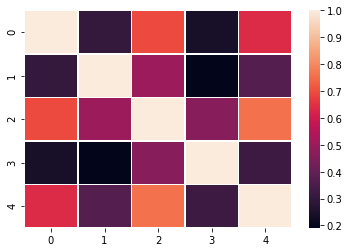

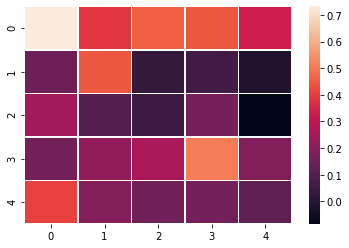

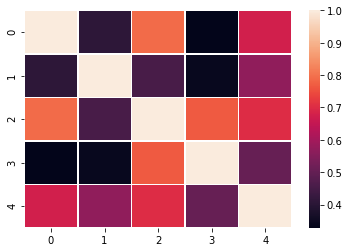

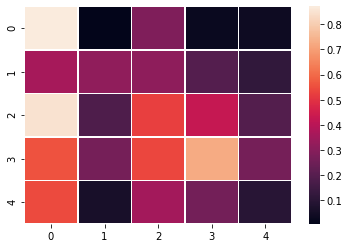

In [17]:
import seaborn as sns
import matplotlib.pylab as plt



ax = sns.heatmap(en_en_sim_matrix, linewidth=0.5)
plt.show()

ax = sns.heatmap(frtoen_en_sim_matrix, linewidth=0.5)
plt.show()

ax = sns.heatmap(fr_fr_sim_matrix, linewidth=0.5)
plt.show()

ax = sns.heatmap(entofr_fr_sim_matrix, linewidth=0.5)
plt.show()
